<font color="#506F87" size=5.5><b>Sistema CBIR (comparación con una query image)</b></font>
<br>
La comparación de una imagen de consulta en el contexto de un dataframe previamente poblado con características extraídas de imágenes de una base de datos es una etapa esencial en el análisis de contenido visual. Este proceso implica evaluar la similitud entre la imagen de consulta y las imágenes existentes en la base de datos en función de las características preextraídas. Dichas características pueden abarcar desde histogramas de color, descriptores locales como SIFT o ORB, hasta representaciones de alto nivel obtenidas mediante modelos de aprendizaje profundo como VGG-16. Al contar con un dataframe estructurado que almacena estas características, se establece una plataforma eficiente para la comparación, permitiendo la identificación de imágenes similares para nuestro sistema de recuperación de imagénes basándose en el contenido.

<font color="#506F87" size=4.5><b>Autores</b></font>
- Mario Serrano Sanchéz
- Pablo Gómez Martín
- Cristina Sandoval Nuño
- Gonzalo Rivera del Pino

## <font color="#506F87" size=5.5><b>Librerías</b></font>

In [1]:
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import models

from retrieval_functions import return_n_nearest_SIFT, return_n_nearest_ORB, return_n_nearest_CNN, return_n_nearest_hist, return_n_nearest_bow, correct_percentage
from visualization_functions import view_results

## <font color="#506F87" size=5.5><b>Cargamos el dataset con las features</b></font>

In [2]:
df_images = pd.read_pickle('Images_df.pkl', compression={'method': 'gzip', 'compresslevel': 3, 'mtime': 1})
df_features = pd.read_pickle('Features_df.pkl', compression={'method': 'gzip', 'compresslevel': 3, 'mtime': 1})

df = pd.concat([df_images, df_features], axis=1)

In [3]:
class_names = df.label.unique()

------------
Elegimos una imagen random del dataset para hacer la query

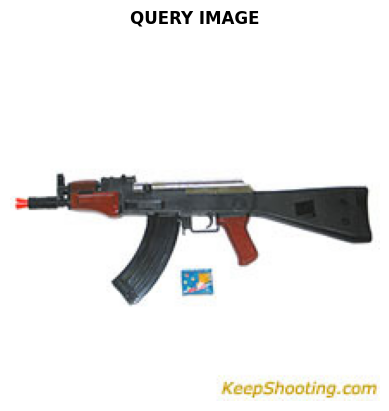

In [27]:
random_number = randint(0, len(df))
query_image, query_label = df.iloc[random_number, 0], df.iloc[random_number, 1]
plt.imshow(query_image)
plt.axis('off')
plt.title('QUERY IMAGE', fontweight='bold')
plt.show()

## <font color="#506F87" size=5.5><b>Matching de descriptores (SIFT and ORB retrieval)</b></font>

**Brute-Force matcher** es sencillo. Toma el descriptor de una característica del primer conjunto y lo compara con todas las demás características del segundo conjunto mediante un cálculo de distancias. Y se devuelve el más cercano.


Para codificar el matcher, primero tenemos que crear el objeto ``BFMatcher`` usando ``cv.BFMatcher()``. Tiene dos parámetros opcionales. El primero es normType. Especifica la medida de distancia a utilizar. Por defecto, es ``cv.NORM_L2``. Es bueno para SIFT, SURF, etc (cv.NORM_L1 también está ahí). El segundo parámetro es la variable booleana crossCheck, que por defecto es falsa. Si es verdadera, Matcher devuelve sólo aquellas coincidencias con valor (i,j) tales que el descriptor i-ésimo del conjunto A tiene como mejor coincidencia el descriptor j-ésimo del conjunto B y viceversa. Es decir, las dos características de ambos conjuntos deben coincidir. Proporciona resultados coherentes y es una buena alternativa a la prueba de proporción propuesta por D.Lowe en <a href=https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf>el paper de SIFT</a>. Nosotros utilizaremos este método de crossCheck, para evitar falsos positivos.

### <font color="#506F87" size=4.75><b>Sift matching</b></font>

Porcentaje de aciertos: 20.0%


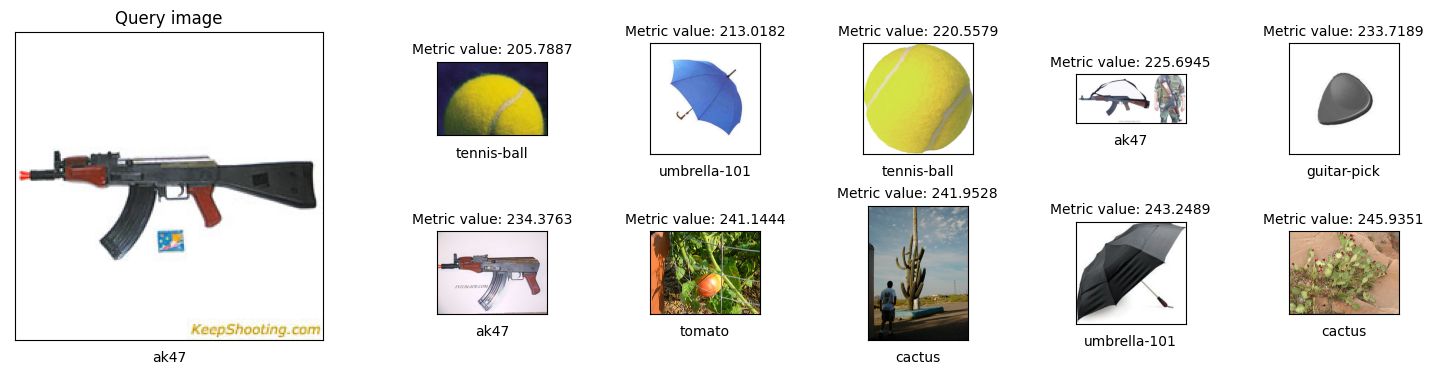

In [28]:
nearest = return_n_nearest_SIFT(query_image, df)
correct_percentage(query_label, nearest, df)
view_results(query_image, query_label, nearest, df)

### <font color="#506F87" size=4.75><b>ORB matching</b></font>

Porcentaje de aciertos: 20.0%


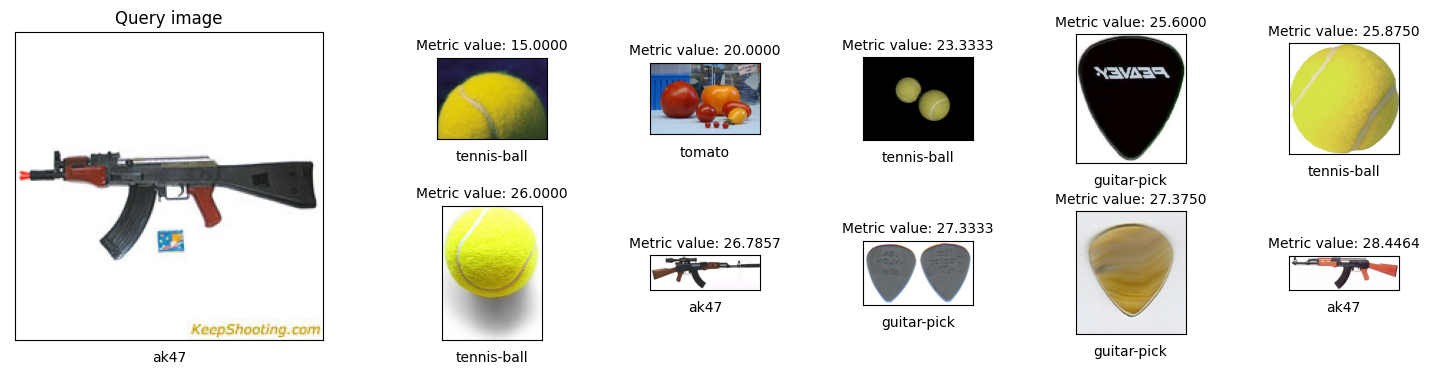

In [29]:
nearest = return_n_nearest_ORB(query_image, df)
correct_percentage(query_label, nearest, df)
view_results(query_image, query_label, nearest, df)

## <font color="#506F87" size=5.5><b>CNN retrieval</b></font>
Para comparar el mapa de características obtenido por VGG-16 primero debemos obtener el mapa de la imagen de consulta. Esto se puede hacer con las funciones ``preprocessing_for_CNN()`` y ``feature_map()`` que se encuentran en feature_extraction_functions.py. Una vez tenemos el mapa de la consulta, lo comparamos con los mapas de las imágenes de la base de datos. Para compararlos podemos usar diferentes distancias, como por ejemplo la <font color="#6D8FA9"><b>distancia euclídea</b></font> o la <font color="#6D8FA9"><b>distancia del coseno</b></font>.

In [30]:
# Download pretrained model
model = models.vgg16(weights='DEFAULT')

Porcentaje de aciertos: 70.0%


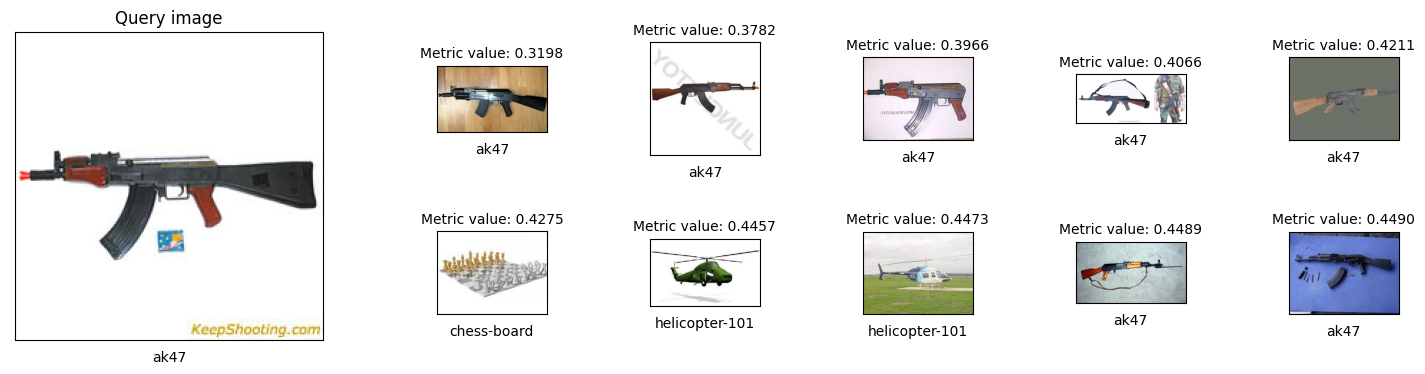

In [31]:
norm = 'cosine'
nearest = return_n_nearest_CNN(query_image, df, model, norm=norm)
correct_percentage(query_label, nearest, df)
view_results(query_image, query_label, nearest, df)

## <font color="#506F87" size=5.5><b>Color histogram retrieval</b></font>
Para comparar los histogramas de color primero debemos obtener el correspondiente histograma de color de de la imagen de consulta. Llamamos histograma de color de la imagen a la concatenación de los histogramas de color de los tres canales _[r, g, b]_. Además se normaliza. Esto se realiza con la función ``get_histogram()`` que se encuentran en feature_extraction_functions.py. Una vez tenemos el histograma de la query image, lo comparamos con el resto de histogramas de la base de datos. Para compararlos podemos usar diferentes distancias, como por ejemplo la <font color="#6D8FA9"><b>distancia euclídea</b></font> o la <font color="#6D8FA9"><b>distancia del coseno</b></font>.

Porcentaje de aciertos: 50.0%


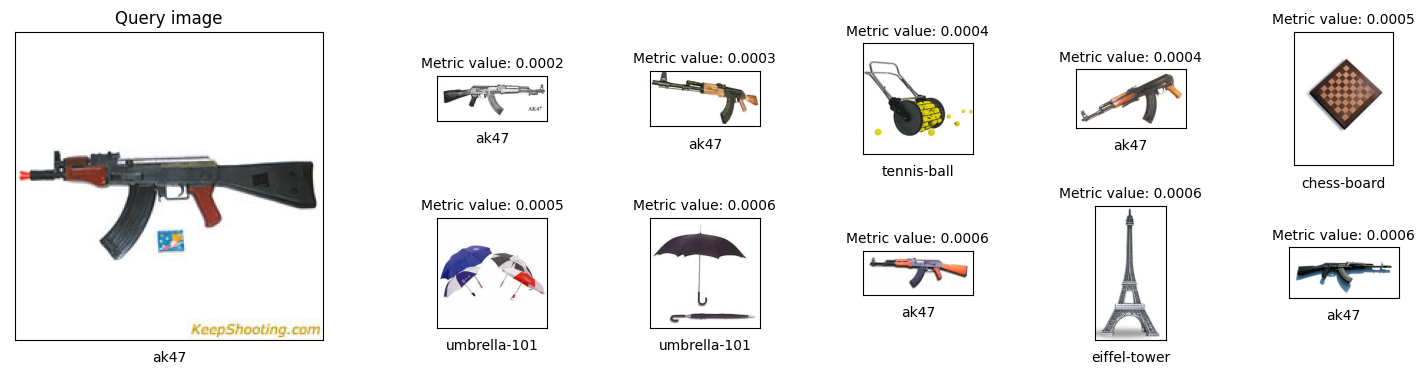

In [32]:
norm = 'cosine'
nearest = return_n_nearest_hist(query_image, df, norm=norm)
correct_percentage(query_label, nearest, df)
view_results(query_image, query_label, nearest, df)

## <font color="#506F87" size=5.5><b>Bag of Words retrieval</b></font>
Para comparar los TF-IDF (_Term Frequency-Inverse Document Frequency_), primero llamamos a la función ``get_tfidf()``, donde se extraen los descriptores SIFT de la imagen consulta y, junto a todos los descriptores del dataset, se lleva a cabo un _clustering_ con K-Means con el que obtendremos el vocabulario de "palabras" visuales, que son asignadas a cada imagen posteriormente. Por último, obtenemos los vectores de frecuencias de las palabras visuales en el dataset para finalmente calcular todos los TF-IDF y almacenarlos en un array, ubicando el de la imagen de consulta en última posición. Para compararlos podemos usar diferentes distancias, como por ejemplo la <font color="#6D8FA9"><b>distancia euclídea</b></font> o la <font color="#6D8FA9"><b>distancia del coseno</b></font>.

Porcentaje de aciertos: 30.0%


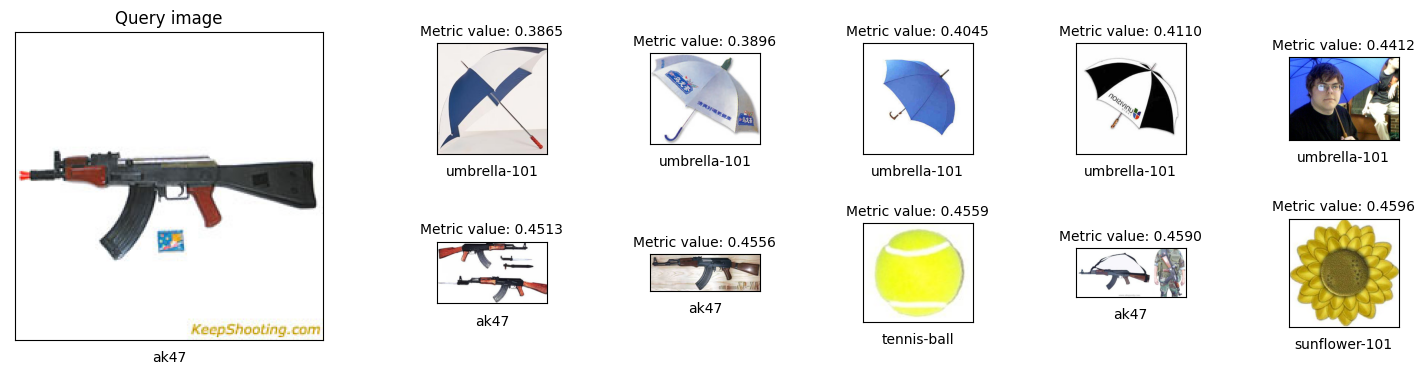

In [33]:
norm = 'cosine'
nearest = return_n_nearest_bow(query_image, df, norm=norm)
correct_percentage(query_label, nearest, df)
view_results(query_image, query_label, nearest, df)

## <font color="#506F87" size=5.5><b>References</b></font>
<font color="#506F87"></font>1. https://www.kaggle.com/datasets/jessicali9530/caltech256/data?select=256_ObjectCategories
<br> 2. https://keras.io/
<br> 3. https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
<br> 4. https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
<br> 5. https://github.com/upm-classes/aapi_2023
<br> 6. https://opencv.org/
<br> 7. https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40